# Hangout Chat Messages

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy
import scipy.stats as stats
import seaborn.apionly as sns
import statsmodels.api as sm
import theano.tensor as tt
from IPython.display import Image

from sklearn import preprocessing

%matplotlib inline
plt.style.use('bmh')
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

## Section 1: Data

In this project we will use a dataset containing Hangout chat messages. We are particularly interested in:

1.	Is response time affected by to whom we are talking to?
2.	Does the environmental factors affect ones's response time (day of week,weekend,)?
3.	What is the best and worst day to get in touch with someone?

This Data is bisa since it was taken from an individual's hangout chat. since response_time is count data, we can model it as a Poisson distribution and estimate its parameter $\mu$.

In [22]:
messages = pd.read_csv('data/hangout_chat_data.csv')
messages.head()

,conversation_id,event_id,timestamp,sender,message_length,num_participants,message_type,prev_timestamp,prev_sender,time_delay_seconds,time_delay_mins,day_of_week,year_month,is_weekend
0,Ugw5Xrm3ZO5mzAfKB7V4AaABAQ,7-H0Z7-FkyB7-HDBYj4KKh,2014-08-15 03:44:12.840015,Mark Regan,14,3,TEXT,2014-08-15 03:44:00.781653,Keir Alexander,12.0,1.0,4,2014-08,0
1,UgwLUkm5oqPrUyjqFlR4AaABAQ,85SWvmXIEV285Sb1E65xL0,2015-10-18 09:36:39.438706,Mark Regan,47,4,TEXT,2015-10-18 09:36:10.932367,Louise Regan,28.0,1.0,6,2015-10,1
2,UgwUBKMcZgFowQTz1Rt4AaABAQ,7-H0Z7-HQQg7-H1JJEmE5K,2013-12-19 02:49:28.552063,Mark Regan,44,2,TEXT,2013-12-19 02:48:50.916592,Daragh Walsh,37.0,1.0,3,2013-12,0
3,UgwUBKMcZgFowQTz1Rt4AaABAQ,7-H0Z7-HQQg7-H1NQV6lMv,2013-12-19 02:50:02.249113,Mark Regan,29,2,TEXT,2013-12-19 02:49:50.401824,Daragh Walsh,11.0,1.0,3,2013-12,0
4,UgwUBKMcZgFowQTz1Rt4AaABAQ,7-H0Z7-HQQg7-H1RPd1OTh,2013-12-19 02:50:34.906922,Mark Regan,102,2,TEXT,2013-12-19 02:50:11.427353,Daragh Walsh,23.0,1.0,3,2013-12,0


let's assume that tendency to reply fast depends on to whom someone is talking to. It is more likely that an individual would reply quickly to his girlfriend than to a distant friend. Estimating parameters $\mu_i$ and $\alpha_i$ for each conversation $i$.

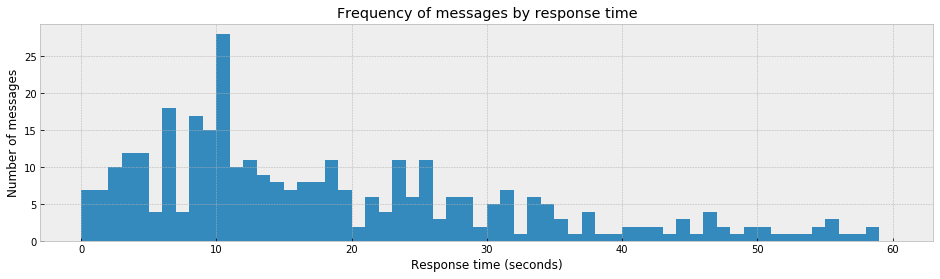

In [23]:
fig = plt.figure(figsize=(16,4))
_ = plt.title('Frequency of messages by response time')
_ = plt.xlabel('Response time (seconds)')
_ = plt.ylabel('Number of messages')
_ = plt.hist(messages['time_delay_seconds'].values, 
             range=[0, 60], bins=60, histtype='stepfilled')

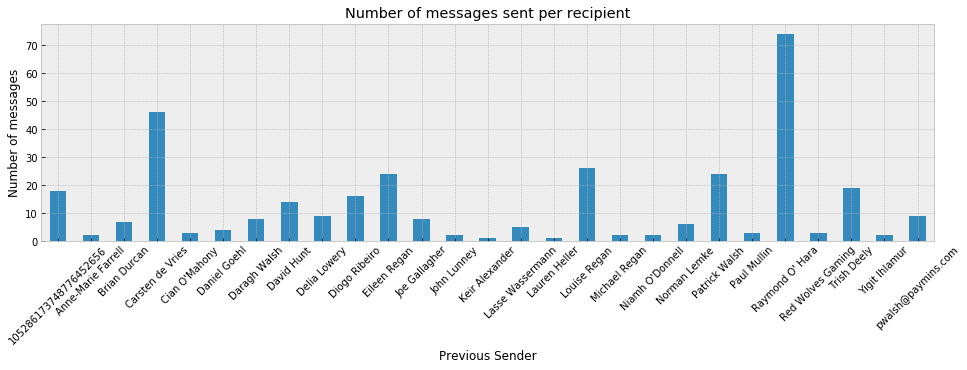

In [24]:
ax = messages.groupby('prev_sender')['conversation_id'].size().plot(
    kind='bar', figsize=(16,4), title='Number of messages sent per recipient', color=colors[0])
_ = ax.set_xlabel('Previous Sender')
_ = ax.set_ylabel('Number of messages')
_ = plt.xticks(rotation=45)

## Poisson Distribution

Poisson distribution gives us the probability of a given number of events happening in a fixed interval of time. A Poisson distribution takes a single parameter $\mu$ which describes both the mean and variance of the data. You can see 3 Poisson distributions below with different values of $\mu$.

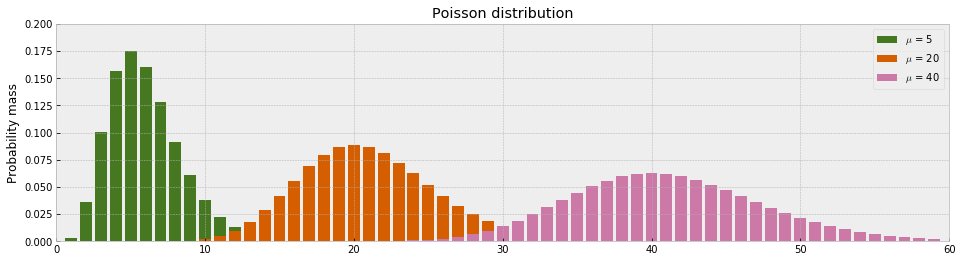

In [5]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(111)
x_lim = 60
mu = [5, 20, 40]
for i in np.arange(x_lim):
    plt.bar(i, stats.poisson.pmf(mu[0], i), color=colors[3])
    plt.bar(i, stats.poisson.pmf(mu[1], i), color=colors[4])
    plt.bar(i, stats.poisson.pmf(mu[2], i), color=colors[5])
    
_ = ax.set_xlim(0, x_lim)
_ = ax.set_ylim(0, 0.2)
_ = ax.set_ylabel('Probability mass')
_ = ax.set_title('Poisson distribution')
_ = plt.legend(['$\mu$ = %s' % mu[0], '$\mu$ = %s' % mu[1], '$\mu$ = %s' % mu[2]])

## MCMC

The MCMC sampler draws parameter values from the prior distribution and computes the likelihood that the observed data came from a distribution with these parameter values.

$$\overbrace{p(\mu \ |\ Data)}^{posterior} \varpropto \overbrace{p(Data \ | \ \mu)}^{likelihood} \cdot \overbrace{p(\mu)}^{prior}$$

It draws values from the paramater priors, it computes the likelihood of these paramters given the data and will try to guide the sampler towards areas of higher probability.

MCMC sampler wanders towards areas of highest likelihood. However, the Bayesian method is not concerned with findings the absolute maximum values but rather to traverse and collect samples around the area of highest probability. All of the samples collected are considered to be a credible parameter.

In [6]:
Image(url='graphics/mcmc-animate.gif')

## Section 2: Model checking

In ths section We aim to answer following question.

1. Are the model and parameters estimated a good fit for the underlying data?

### Posterior Predictive Check

The posterior predictive check generate new data from the predicted model. if the model is a good fit for the underlying data then the generated data should resemble the original observed data.

In [7]:
with pm.Model() as model:
    mu = pm.Uniform('mu', lower=0, upper=100)
    y_est = pm.Poisson('y_est', mu=mu, observed=messages['time_delay_seconds'].values)

    y_pred = pm.Poisson('y_pred', mu=mu)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(5000, step, start=start, progressbar=True)

C:\Users\salee\Anaconda3\lib\site-packages\pymc3\tuning\starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -7,014.3, ||grad|| = 5,369: 100%|████████████████████████████████████████████████| 8/8 [00:00<00:00, 103.91it/s]
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [y_pred]
>Metropolis: [mu]
Sampling 4 chains: 100%|██████████████████████████████████████████████████████| 22000/22000 [03:40<00:00, 99.60draws/s]
The number of effective samples is smaller than 10% for some parameters.


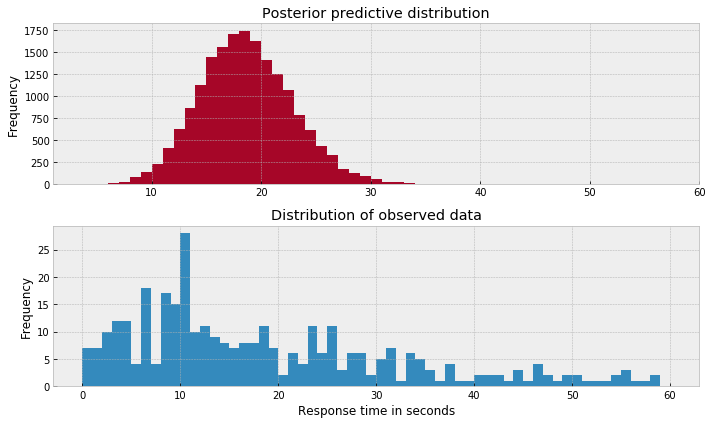

In [8]:
x_lim = 60
burnin = 500

y_pred = trace[burnin:].get_values('y_pred')
mu_mean = trace[burnin:].get_values('mu').mean()

fig = plt.figure(figsize=(10,6))
fig.add_subplot(211)

_ = plt.hist(y_pred, range=[0, x_lim], bins=x_lim, histtype='stepfilled', color=colors[1])   
_ = plt.xlim(1, x_lim)
_ = plt.ylabel('Frequency')
_ = plt.title('Posterior predictive distribution')

fig.add_subplot(212)

_ = plt.hist(messages['time_delay_seconds'].values, range=[0, x_lim], bins=x_lim, histtype='stepfilled')
_ = plt.xlabel('Response time in seconds')
_ = plt.ylabel('Frequency')
_ = plt.title('Distribution of observed data')

plt.tight_layout()

## Section 3: Poisson Regression

### Hierarchical Model

Bayesian Hierarchical Model is a statistical model with multiple levels (hierarchical form) that estimates the parameters of the posterior distribution using the Bayesian method. Hierarchical modeling has the potential to overrule classical methods in applications where respondents give multiple observational data moreover, the model has proven to be robust, with the posterior distribution less sensitive to the more flexible hierarchical priors. It is used when information is available on several different levels of observational units.

To construct a Poisson regression in PyMC3, we need to apply the log link function to $\mu$.  The underlying data model in PyMC3 uses theano and hence we need to use the theano tensor method `theano.tensor.exp()` as shown below.

In [9]:
X = messages[['is_weekend','day_of_week','message_length','num_participants']].values
_, num_X = X.shape

with pm.Model() as model:       
    intercept = pm.Normal('intercept', mu=0, sd=100)
    beta_message_length = pm.Normal('beta_message_length', mu=0, sd=100)
    beta_is_weekend = pm.Normal('beta_is_weekend', mu=0, sd=100)
    beta_num_participants = pm.Normal('beta_num_participants', mu=0, sd=100)
    
    mu = tt.exp(intercept 
                + beta_message_length*messages.message_length 
                + beta_is_weekend*messages.is_weekend
                + beta_num_participants*messages.num_participants)
    
    y_est = pm.Poisson('y_est', mu=mu, observed=messages['time_delay_seconds'].values)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(5000,step, start=start, progressbar=True)

logp = -2,237.7, ||grad|| = 2,909.8: 100%|█████████████████████████████████████████████| 59/59 [00:10<00:00,  5.63it/s]
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta_num_participants]
>Metropolis: [beta_is_weekend]
>Metropolis: [beta_message_length]
>Metropolis: [intercept]
Sampling 4 chains: 100%|██████████████████████████████████████████████████████| 22000/22000 [52:45<00:00,  6.95draws/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


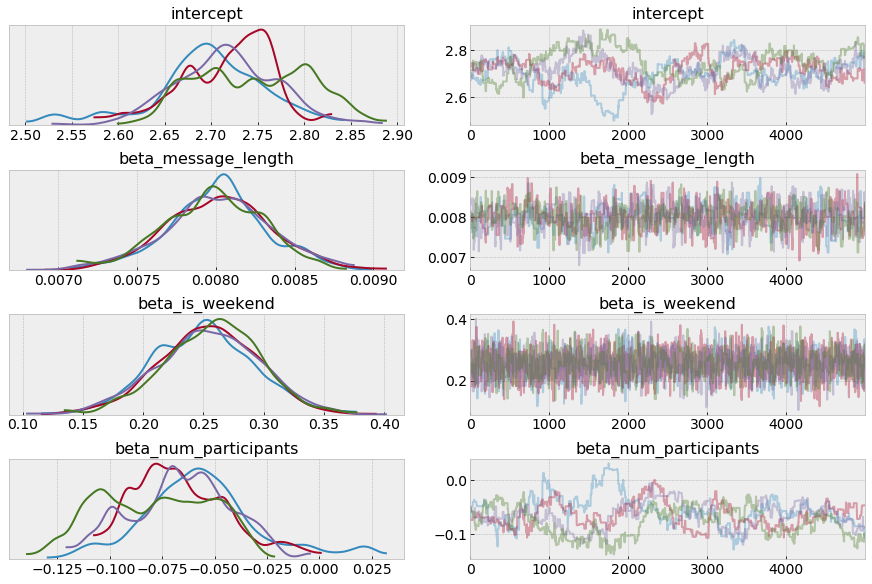

In [10]:
_ = pm.traceplot(trace)

As you can see from the above results, the baseline intercept $\beta_0$ has an estimated value of between 2.5 and 2.9.

> For a Poisson model, given a unit change in $x$, the fitted $\hat y$ changes by $\hat y \left( e^\beta - 1 \right)$

The main takeaway from this is that the effect of changing x depends on the current value of y. Unlike the simple linear regression, a unit change in x does not cause a consistent change in y.

###  Marginal and pairwise density plots

The below plot shows the marginal densities (across the diagonal) and the pairwise densities (lower and upper panes). This plot is very useful for understanding how covariates interact with one another. In the above example, we can see that as the number of participants increases, the baseline intercept decreases. 

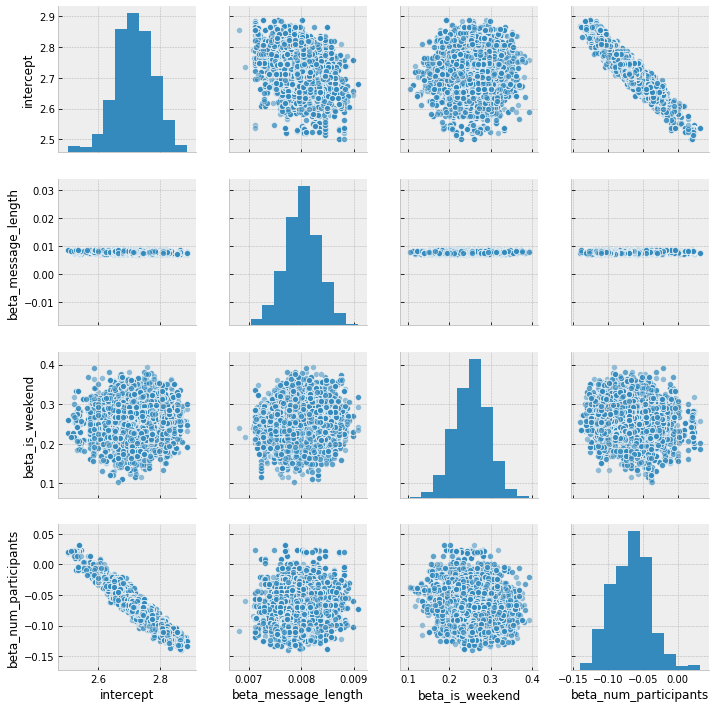

In [11]:
_ = sns.pairplot(pm.trace_to_dataframe(trace[500:]), plot_kws={'alpha':.5})

### Mixed effects poisson regression

We can make a small extension to the above model by including a random intercept parameter. This will allow us to estimate a baseline parameter value $\beta_0$ for each person I communicate with. For all other parameters I will estimate a parameter across the entire population. For each person i and each message j, this is formally represented as:

$$y_{ji} \sim Poi(\mu)$$
$$\mu = \beta_{0_i} + \beta_1 x_1 ... \beta_n x_n$$

By introducing this random effects parameter $\beta_0$ for each person i, it allows the model to establish a different baseline for each person responded to - whilst estimating the  effects of the covariates on the response for the entire population.

In [25]:
# Convert categorical variables to integer
le = preprocessing.LabelEncoder()
participants_idx = le.fit_transform(messages['prev_sender'])
participants = le.classes_
n_participants = len(participants)

with pm.Model() as model:

    intercept = pm.Normal('intercept', mu=0, sd=100, shape=n_participants)
    slope_message_length = pm.Normal('slope_message_length', mu=0, sd=100)
    slope_is_weekend = pm.Normal('slope_is_weekend', mu=0, sd=100)
    slope_num_participants = pm.Normal('slope_num_participants', mu=0, sd=100)
    
    mu = tt.exp(intercept[participants_idx] 
                + slope_message_length*messages.message_length 
                + slope_is_weekend*messages.is_weekend
                + slope_num_participants*messages.num_participants)
    
    y_est = pm.Poisson('y_est', mu=mu, observed=messages['time_delay_seconds'].values)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(500, step, start=start, progressbar=True)

C:\Users\salee\Anaconda3\lib\site-packages\pymc3\tuning\starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -2,216.2, ||grad|| = 17.297: 100%|██████████████████████████████████████████| 1192/1192 [03:13<00:00,  6.16it/s]
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [slope_num_participants]
>Metropolis: [slope_is_weekend]
>Metropolis: [slope_message_length]
>Metropolis: [intercept]
Sampling 4 chains: 100%|████████████████████████████████████████████████████████| 4000/4000 [09:50<00:00,  6.77draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameter

In [ ]:
_ = pm.traceplot(trace[499:])

C:\Users\salee\Anaconda3\lib\site-packages\arviz\data\base.py:141: SyntaxWarning: More chains (4) than draws (1). Passed array should have shape (chains, draws, *shape)
  SyntaxWarning,
C:\Users\salee\Anaconda3\lib\site-packages\arviz\plots\kdeplot.py:311: UserWarning: kde plot failed, you may want to check your data
  warnings.warn("kde plot failed, you may want to check your data")
C:\Users\salee\Anaconda3\lib\site-packages\arviz\plots\traceplot.py:286: UserWarning: Attempting to set identical left == right == <xarray.DataArray 'draw' ()>
array(0) results in singular transformations; automatically expanding.
  axes[idx, 1].set_xlim(left=data.draw.min(), right=data.draw.max())
C:\Users\salee\Anaconda3\lib\site-packages\arviz\plots\kdeplot.py:311: UserWarning: kde plot failed, you may want to check your data
  warnings.warn("kde plot failed, you may want to check your data")
C:\Users\salee\Anaconda3\lib\site-packages\arviz\plots\traceplot.py:286: UserWarning: Attempting to set identica

C:\Users\salee\Anaconda3\lib\site-packages\arviz\plots\kdeplot.py:311: UserWarning: kde plot failed, you may want to check your data
  warnings.warn("kde plot failed, you may want to check your data")
C:\Users\salee\Anaconda3\lib\site-packages\arviz\plots\traceplot.py:286: UserWarning: Attempting to set identical left == right == <xarray.DataArray 'draw' ()>
array(0) results in singular transformations; automatically expanding.
  axes[idx, 1].set_xlim(left=data.draw.min(), right=data.draw.max())
C:\Users\salee\Anaconda3\lib\site-packages\arviz\plots\kdeplot.py:311: UserWarning: kde plot failed, you may want to check your data
  warnings.warn("kde plot failed, you may want to check your data")
C:\Users\salee\Anaconda3\lib\site-packages\arviz\plots\traceplot.py:286: UserWarning: Attempting to set identical left == right == <xarray.DataArray 'draw' ()>
array(0) results in singular transformations; automatically expanding.
  axes[idx, 1].set_xlim(left=data.draw.min(), right=data.draw.max()

## Section 4: Results

The interpretation of the above results are interesting:
- Each person has a different baseline response rate
- Longer messages take marginally longer to respond to
- You are more likely to get a slow response if you message someone on the weekend
- people tend to reply more quickly to conversations that have multiple people added to it (group  chat)

And after accounting for the effect of each covariate on the response, the model estimates the below $\beta_0$ parameters.

C:\Users\salee\Anaconda3\lib\site-packages\pymc3\plots\__init__.py:40: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


<Figure size 1152x288 with 0 Axes>

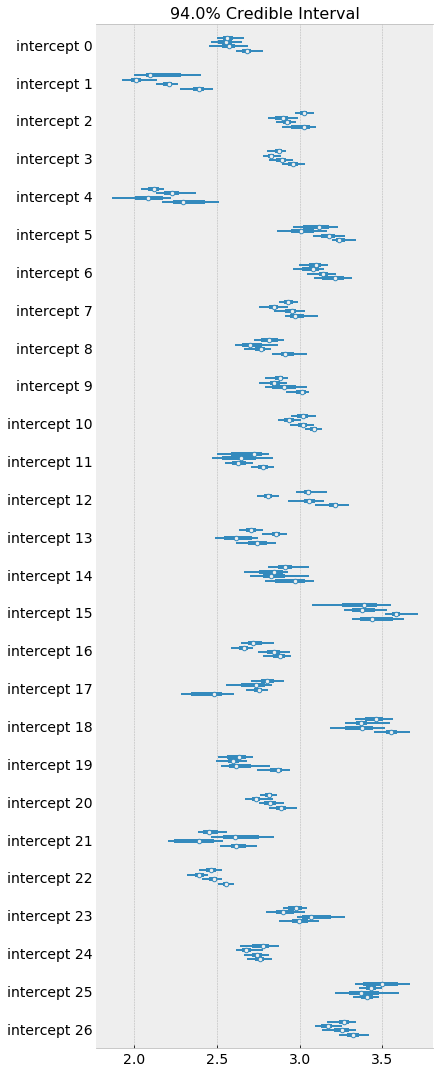

In [38]:
_ = plt.figure(figsize=(16,4))
_ = pm.forestplot(trace[50:], varnames=['intercept'])